# Evaluating the Impact of a Job Training Program on Real Earnings

This project investigates whether participation in a job training program improves real earnings using statistical modeling. We use exploratory data analysis (EDA), and treatment effect modeling to evaluate outcomes.


In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from scipy.stats import ttest_ind
from sklearn.neighbors import NearestNeighbors
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

Business Context: In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted us as a data science consultant to assist them with this task.

Business Problem: Evaluate whether the job training program causes the earnings of disadvantaged workers to go up.
Analytical Context. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [2]:
df = pd.read_csv('lalonde.csv', index_col=0)
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## Step 1:
Summary Statistics and Exporatory Data Analysis (EDA)

In [3]:
stats=df.describe()
mean_re74 = np.mean(df['re74'])
mean_re75 = np.mean(df['re75'])
mean_re78 = np.mean(df['re78'])
income_decrease = df[df['re75'] < df['re74']].shape[0]
total_population = df.shape[0]
percentage_decrease = (income_decrease / total_population) * 100


print(stats)
print(f"Percentage of population with decreased income (1974-1975): {percentage_decrease:.2f}%")
print("Average income in 1974:", mean_re74)
print("Average income in 1975:", mean_re75)
print("Average income in 1978:", mean_re78)

            treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
min      0.000000     

From 1974 to 1975, there was a dip in average income by over 2000 dollars, from 4557 to 2184 dollars. In these two years, the percentage of the population with a decreased income was 46.42 percent. From 1975 to 1978, there was a massive increase in average income of over 4000 dollars, from 2184 to 6792 dollars. Due to the overall average income dip, a high percentage of people experienced a decrease in overall income, and the rebound in 1978, all these signs point to an economic reason rather than a person.

The economic downturn in 1975 could be attributed to the 1973-1975 recession, which was driven by:
Oil Crisis (1973): A sharp rise in oil prices led to economic contraction.
High Inflation & Unemployment: Stagflation (high inflation + stagnation) affected income and employment opportunities.
Stock Market Decline: The financial instability impacted investments and wages.

In [4]:
earnings_cols = ['re74', 're75', 're78']
pct_treated = np.mean(df['treat']) * 100

for col in earnings_cols:
    treat_data = df.loc[df['treat'] == 1, col]
    control_data = df.loc[df['treat'] == 0, col]
    
    treat_mean = treat_data.mean()
    control_mean = control_data.mean()
    mean_diff = control_mean - treat_mean
    
    treat_median = treat_data.median()
    control_median = control_data.median()
    median_diff = control_median - treat_median
    
    t_stat, p_val = ttest_ind(treat_data, control_data, equal_var=False)
    
    print(f"--- {col} ---")
    print(f"Mean (Treatment): {treat_mean:.2f}, Mean (Control): {control_mean:.2f}, Diff: {mean_diff:.2f}")
    print(f"Median (Treatment): {treat_median:.2f}, Median (Control): {control_median:.2f}, Diff: {median_diff:.2f}")
    print(f"T-stat: {t_stat:.2f}, p-value: {p_val:.4f}\n")
print(f"{pct_treated:.2f}% of the dataset is in the treatment group.")

--- re74 ---
Mean (Treatment): 2095.57, Mean (Control): 5619.24, Diff: 3523.66
Median (Treatment): 0.00, Median (Control): 2547.05, Diff: 2547.05
T-stat: -7.25, p-value: 0.0000

--- re75 ---
Mean (Treatment): 1532.06, Mean (Control): 2466.48, Diff: 934.43
Median (Treatment): 0.00, Median (Control): 1086.73, Diff: 1086.73
T-stat: -3.28, p-value: 0.0012

--- re78 ---
Mean (Treatment): 6349.14, Mean (Control): 6984.17, Diff: 635.03
Median (Treatment): 4232.31, Median (Control): 4975.51, Diff: 743.20
T-stat: -0.94, p-value: 0.3491

30.13% of the dataset is in the treatment group.


The differnce of means in 1974 is statistically significant
The differnce of means in 1975 is statistically significant
The differnce of means in 1978 is not statistically significant

-------

Does your previous result mean that the treatment had a negative impact? Why or why not?

If we solely base our findings on the data, it does suggest that the result would have a negative impact because the treatment group had lower earnings than the control group in all years. However, this interpretation would be incorrect if you apply business and data understanding. First, the treatment groups had significantly lower earnings than the control group before the program. Thus, it reflects pre-existing differences, not newfound ones. Secondly, many individuals in the treatment group were likely out of work due to the training and economic downturn. Conversely, the people in the control group were most likely still in work, especially because many already hold degrees, which can help ensure job security. Furthermore, in 1978, the earning gap between the two groups became statistically insignificant, suggesting that the treatment group caught up to the control group over time because of the training. If the program had no impact or long-term negative impact, we expect the gap to remain large and statistically significant.

-------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

In [5]:
treatment_group = df[df['treat'] == 1]
control_group = df[df['treat'] == 0]

def compute_smd(feature):
    mean_treatment = treatment_group[feature].mean()
    mean_control = control_group[feature].mean()
    var_treatment = treatment_group[feature].var()
    var_control = control_group[feature].var()
    smd = (mean_treatment - mean_control) / np.sqrt((var_treatment + var_control) / 2)
    return smd

covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
smd_results = {feature: compute_smd(feature) for feature in covariates}
print("Standardized Mean Differences (SMD) for Covariates:")
for feature, smd_value in smd_results.items():
    print(f"{feature}: SMD = {smd_value:.4f}")

Standardized Mean Differences (SMD) for Covariates:
age: SMD = -0.2419
educ: SMD = 0.0448
black: SMD = 1.6677
hispan: SMD = -0.2769
married: SMD = -0.7195
nodegree: SMD = 0.2350
re74: SMD = -0.5958
re75: SMD = -0.2870


The groups that are imbalanced are age, black, hispan, married, nodegree, re74 and re75

-------

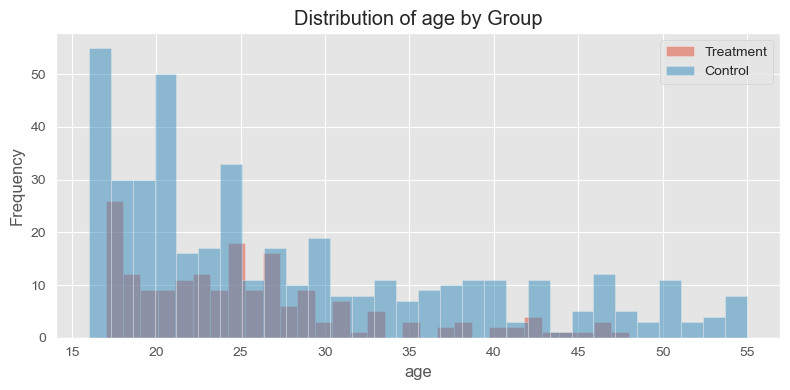

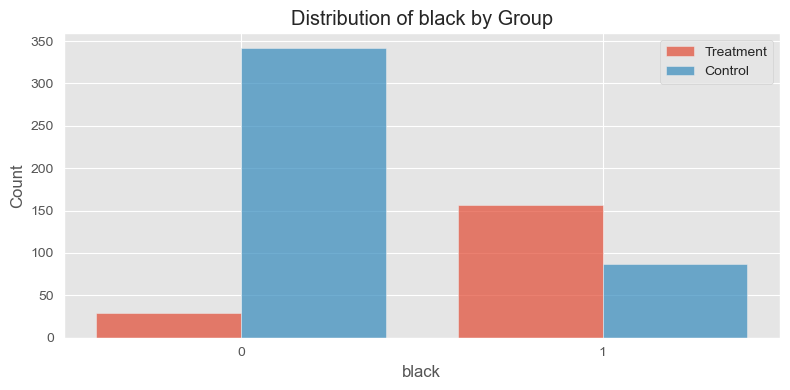

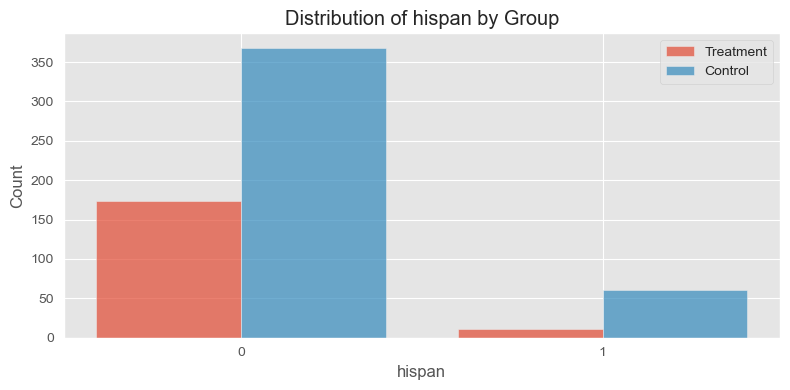

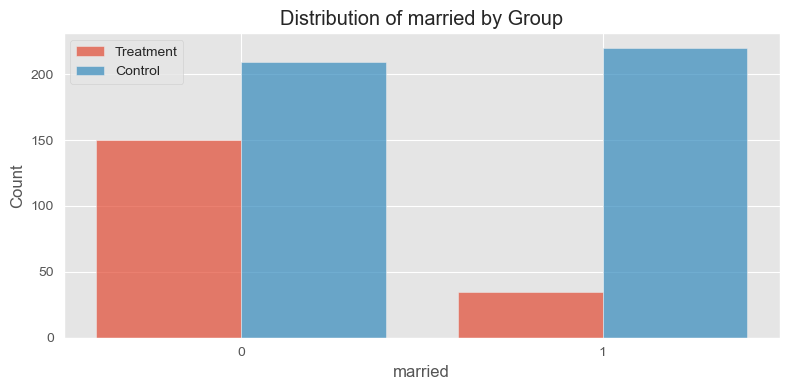

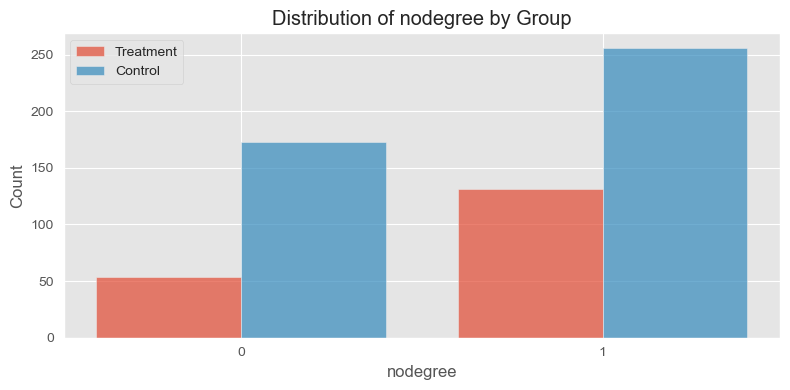

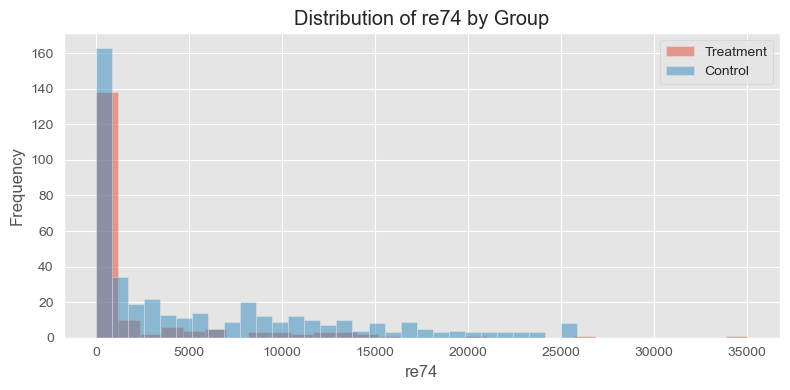

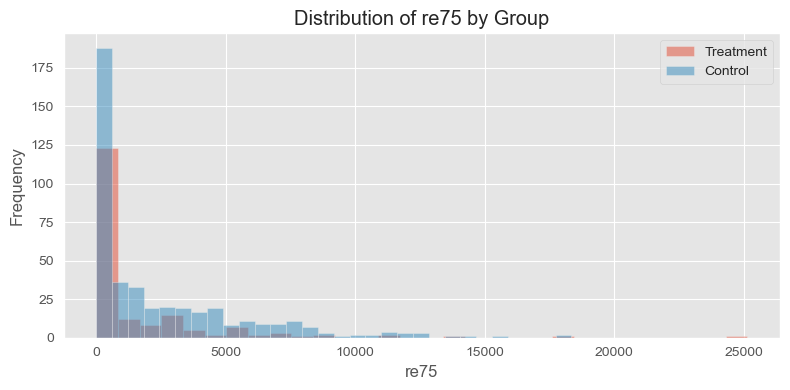

In [6]:
imbalanced_covariates = ["age", "black", "hispan", "married",  "nodegree", "re74", "re75"]
for cov in imbalanced_covariates:
    treat_data = treatment_group[cov]
    control_data = control_group[cov]
    plt.figure(figsize=(8, 4))
    
    unique_vals = df[cov].unique()
    if len(unique_vals) <= 2 and sorted(unique_vals) in [[0, 1], [1, 0]]:
        treat_counts = treat_data.value_counts()
        control_counts = control_data.value_counts()
        treat_0 = treat_counts.get(0, 0)
        treat_1 = treat_counts.get(1, 0)
        control_0 = control_counts.get(0, 0)
        control_1 = control_counts.get(1, 0)
        x_positions = np.array([0, 1])
        bar_width = 0.4
        plt.bar(x_positions - bar_width/2, [treat_0, treat_1],
                width=bar_width, label="Treatment", alpha=0.7)
        plt.bar(x_positions + bar_width/2, [control_0, control_1],
                width=bar_width, label="Control", alpha=0.7)
        plt.xticks(x_positions, ["0", "1"])
        plt.xlabel(cov)
        plt.ylabel("Count")
        plt.title(f"Distribution of {cov} by Group")
        plt.legend()
    else:
        plt.hist(treat_data, bins=30, alpha=0.5, label="Treatment")
        plt.hist(control_data, bins=30, alpha=0.5, label="Control")
        plt.xlabel(cov)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {cov} by Group")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

-------

<h2>Propensity score matching using logistic regression</h2>

In order to balance the covariates of the control and treatment groups, we will use matching. 
Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.
We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the propensity score which helps us do the matching on select features in an efficient way. The key idea is that the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

## Step 2 Estimate the propestity score:
We Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. 

In [7]:
y = df['treat']
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0)  
print(result.summary())
df['pscore']=result.predict(X) 
print(df[['treat', 'pscore']].head()) 

                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.3508
Time:                        22:12:00   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.0

Interpreting findings:

black = 3.0654: Being black is associated with an increase of ~3.07 in log odds of treatment, e^(3.07)=21.4. So, controlling for other variables, a black individual has about 21 times higher odds of being in the treatment group as opposed to the control group.

Hispanic=0.9836: Being Hispanic is associated with an increase of ~0.9836 in log odds of treatment, e (0.9836)=2.674. So, controlling for other variables, a Hispanic individual has about 2.674 times higher odds of being in the treatment group than the control group.

Married = -0.8321: Being married lowers the log-odds of treatment by ~0.83 e^(-0.83)=0.44, suggesting married individuals are less likely to be in the treatment group

re74 = -7.178e-05: Since the coefficient is negative, it means higher earnings in 1974 (re74) are associated with a lower probability of being in the treatment group however this number is very small because earnings are significant numbers. Hence, the effect of one extra dollar is minimal. A $1 increase in earnings in 1974 reduces the log odds of being in the treatment group by 0.00007178. Interestingly, in re75, since the coefficient is positive, the higher earnings in 1975 are associated with a slightly higher probability of being in the treatment group.

Pseudo R-squared(0.3508) indicates that the model does a mediocre job differentiating between treatment and control individuals.

Pscores: These scores reflect the model's estimation of each individual's likelihood of being in the treatment group given their baseline characteristics. The variation in scores highlights heterogeneity among the treated subjects, which is important to consider when matching or weighting to ensure overlap between the treatment and control groups. Their predicted probabilities vary from 22 percent to 78 percent. This is because of each individual's differences regarding their characteristics (e.g., age, prior earnings, race, education).

-------

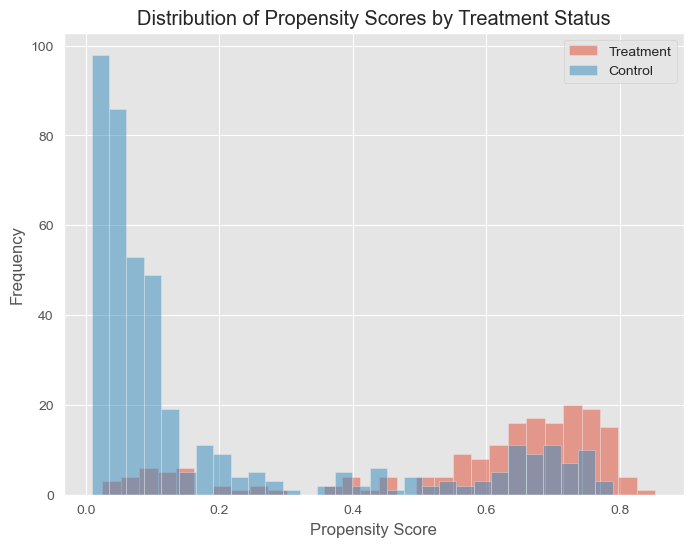

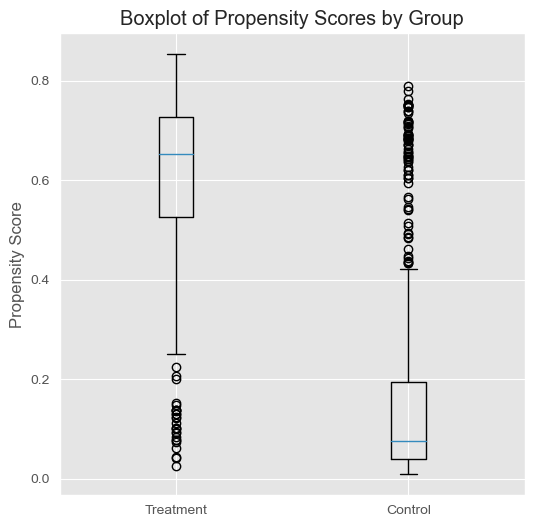

In [8]:
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = df[covariates]
X = sm.add_constant(X)
y = df['treat']
logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0)  
pscore_logit = result.predict(X)
df['pscore_logit'] = pscore_logit

plt.figure(figsize=(8, 6))
plt.hist(pscore_logit[df['treat'] == 1], bins=30, alpha=0.5, label='Treatment')
plt.hist(pscore_logit[df['treat'] == 0], bins=30, alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores by Treatment Status')
plt.legend()
plt.show()
pscore_t = df.loc[df['treat'] == 1, 'pscore_logit']
pscore_c = df.loc[df['treat'] == 0, 'pscore_logit']
plt.figure(figsize=(6, 6))
plt.boxplot([pscore_t, pscore_c], labels=["Treatment", "Control"])
plt.ylabel("Propensity Score")
plt.title("Boxplot of Propensity Scores by Group")
plt.show()

-------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

## Step 3:
In this step, we will use the sklearn.neighbors function NearestNeighbors to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.</p>

We will seperate the propensity scores using step 2 for treatment and control groups. We will call these<code>treat_pscores</code> and <code>control_pscores</code> respectively. Futhermore we will Use the <code>control_pscores</code> to train a $k$-NN algorithm with $k=5$.</p>

In [9]:
treated_data = df[df['treat'] == 1].copy()
control_data = df[df['treat'] == 0].copy()
treated_pscores = treated_data['pscore_logit'].values.reshape(-1, 1)
control_pscores = control_data['pscore_logit'].values.reshape(-1, 1)

-------

In [10]:
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(control_pscores)
distances, indices = knn.kneighbors(treated_pscores)
print(indices[10])
print(distances[10])

[268 172 325 415 265]
[0.00068693 0.0007094  0.00258175 0.00283832 0.00336758]


-------

In [11]:
closest_control_indices = indices[:, 0]
matched_control_df = control_data.iloc[closest_control_indices].copy()
matched_treated_df = treated_data.copy()
print("Treatment Group Shape: ", matched_treated_df.shape)  
print("Matched Control Group Shape: ", matched_control_df.shape)  
print(matched_treated_df.head())
print(matched_control_df.head())

Treatment Group Shape:  (185, 12)
Matched Control Group Shape:  (185, 12)
      treat  age  educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1   37    11      1       0        1         1   0.0   0.0   
NSW2      1   22     9      0       1        0         1   0.0   0.0   
NSW3      1   30    12      1       0        0         0   0.0   0.0   
NSW4      1   27    11      1       0        0         1   0.0   0.0   
NSW5      1   33     8      1       0        0         1   0.0   0.0   

            re78    pscore  pscore_logit  
NSW1   9930.0460  0.638770      0.638770  
NSW2   3595.8940  0.224634      0.224634  
NSW3  24909.4500  0.678244      0.678244  
NSW4   7506.1460  0.776324      0.776324  
NSW5    289.7899  0.701639      0.701639  
         treat  age  educ  black  hispan  married  nodegree         re74  \
PSID69       0   30    17      1       0        0         0  17827.37000   
PSID111      0   51    11      0       0        0         1     48.98167   
PSID370

-------

<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

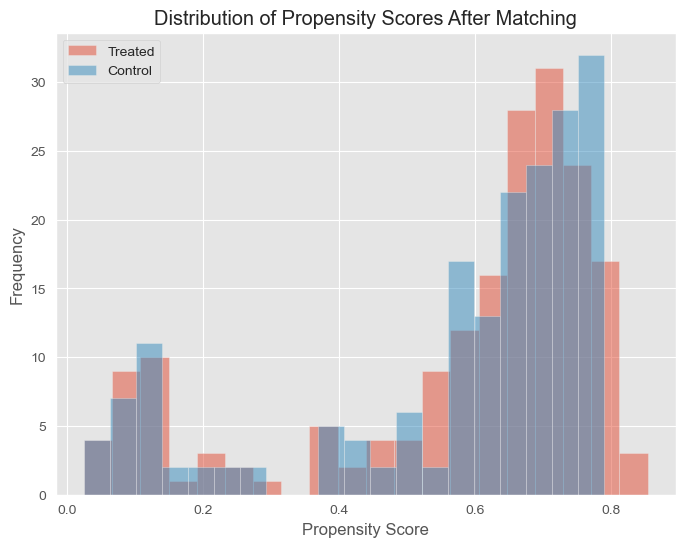

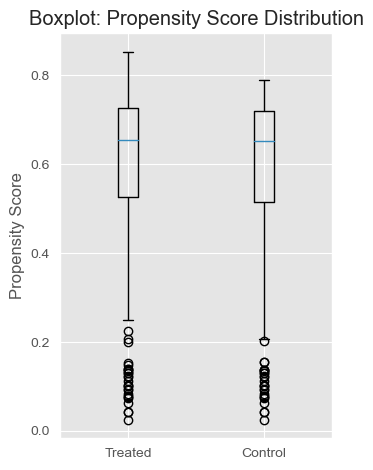

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(matched_treated_df['pscore_logit'], bins=20, alpha=0.5, label='Treated')
plt.hist(matched_control_df['pscore_logit'], bins=20, alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores After Matching')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
data_to_plot = [matched_treated_df['pscore_logit'], matched_control_df['pscore_logit']]
plt.boxplot(data_to_plot, labels=['Treated', 'Control'])
plt.ylabel('Propensity Score')
plt.title('Boxplot: Propensity Score Distribution')

plt.tight_layout()
plt.show()

Histogram Comparison:
Before matching, a pronounced imbalance exists between the treatment and control groups. Individuals in the control group predominantly have low propensity scores, typically between 0 and 0.2, with high frequency. This distribution indicates that, based on characteristics such as age, ethnicity, and education, these individuals have significantly lower probabilities of participating in the job training program. In contrast, individuals in the treatment group mainly possess higher propensity scores above 0.5. Only a small proportion of individuals within the treated group have low propensity scores. The distinct separation of propensity scores between these two groups highlights selection biases stemming from differences in observed characteristics.
After matching, the distribution of propensity scores between the treated and control groups is considerably more balanced. Significant overlap exists between the groups across the entire propensity score distribution, reflecting that the matching process effectively addressed observable differences. This enhanced balance suggests that the matched groups now provide a more accurate basis for estimating the true impact of the job training program, as the potential for bias from observed covariates has been significantly reduced.
Boxplot Comparison:
The boxplots illustrate the imbalance between the treatment and control groups before matching. Approximately 50% of individuals in the treatment group exhibit propensity scores ranging from about 0.55 to 0.75, while the central propensity scores for the control group cluster within a much lower range, approximately between 0.1 and 0.2. Additionally, the minimum propensity scores within the treatment group show considerable variability, extending downwards to approximately 0.25, while the control group's maximum propensity scores rarely exceed 0.42. These differences underscore a clear pattern: individuals in the treatment group have substantially higher propensity scores compared to those in the control group. Although outliers and exceptions are visible in both groups, the overarching trend of significant imbalance is evident. After matching, the second boxplot demonstrates substantial improvements in balance between the two groups, with their distributions becoming considerably more aligned. This alignment emphasizes how matching effectively reduces selection bias, creating comparable and better-suited groups for unbiased causal inference regarding the effects of the job training program.

-------

## Step 4:

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

In [13]:
unmatched_treated_df = df[df['treat'] == 1].copy()
unmatched_control_df = df[df['treat'] == 0].copy()

def var_before_matching(col):
    var_t = unmatched_treated_df[col].var()
    var_c = unmatched_control_df[col].var()
    return (var_t, var_c)

balance_metrics = {}

for cov in covariates:
    mean_treat_after = matched_treated_df[cov].mean()
    mean_control_after = matched_control_df[cov].mean()
    mean_diff_after = mean_treat_after - mean_control_after

    var_treat_before = unmatched_treated_df[cov].var()
    var_control_before = unmatched_control_df[cov].var()

    asmd = abs(mean_diff_after) / np.sqrt((var_treat_before + var_control_before) / 2)
    balance_metrics[cov] = asmd

for cov, asmd_val in balance_metrics.items():
    print(f"{cov}: ASMD = {asmd_val:.3f}")

age: ASMD = 0.187
educ: ASMD = 0.013
black: ASMD = 0.014
hispan: ASMD = 0.018
married: ASMD = 0.132
nodegree: ASMD = 0.011
re74: ASMD = 0.041
re75: ASMD = 0.009


Threshold for ASMD: Values below 0.1 are considered well-balanced, Values between 0.1 and 0.2 are borderline unbalanced, and Values above 0.2 often signal more serious imbalance.

Interpretations: re74, re75, no degree,hispan, black, and educ, are now well balanced. Only married and age are considered borderline unbalanced now. Because of our matching using k-nearest neighbors, we could balance, or somewhat balance, all of our previously unbalanced groups.

-------

In [14]:
mean_treated = matched_treated_df['re78'].mean()
mean_control = matched_control_df['re78'].mean()
att_estimate = mean_treated - mean_control

stat, pvalue = ttest_ind(matched_treated_df['re78'], matched_control_df['re78'], equal_var=False)  

print(f"T-statistic: {stat:.2f}, P-value: {pvalue:.4f}")
print(f"Mean re78 (Treated):  {mean_treated:.2f}")
print(f"Mean re78 (Control): {mean_control:.2f}")
print(f"Estimated ATT:       {att_estimate:.2f}")

T-statistic: 2.55, P-value: 0.0111
Mean re78 (Treated):  6349.14
Mean re78 (Control): 4538.86
Estimated ATT:       1810.29


These findings imply that the job training program (or treatment) increased the earnings of participants by roughly $1,810 in 1978, on average, relative to a comparable control group. This significant positive effect supports the conclusion that the treatment effectively boosted wages. However, as with any observational study, it is important to consider that while matching has improved the balance of observed covariates, unobserved confounding factors might still be present.

-------

<h2>Propensity score matching using decision trees and random forests</h2>

## Step 5:
<p>To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.</p>

In [15]:
y = df['treat']
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]

tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X, y)

df['pscore_tree'] = tree_model.predict(X)
print(df[['treat', 'pscore_tree']].head(10))

       treat  pscore_tree
NSW1       1     0.864583
NSW2       1     0.500000
NSW3       1     0.864583
NSW4       1     0.864583
NSW5       1     0.864583
NSW6       1     0.864583
NSW7       1     0.864583
NSW8       1     0.864583
NSW9       1     0.864583
NSW10      1     0.083333


-------

Estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics.

In [16]:
new_df=df.drop(columns=['treat','re78'])
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(tree_model,filled=True,feature_names=new_df.columns)
fig.savefig('tree.png')

The estimated probability of a hispanic person that meets all those characterisitcs is 0%. The probability of a black person that meets all those characterisitcs is 59.5%.

-------

In [17]:
y = df['treat']
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X, y)
df['pscore_forest'] = rf_model.predict_proba(X)[:, 1]
print(df[['treat', 'pscore_forest']].head(10))

       treat  pscore_forest
NSW1       1       0.633292
NSW2       1       0.389846
NSW3       1       0.735352
NSW4       1       0.756030
NSW5       1       0.728521
NSW6       1       0.734169
NSW7       1       0.726273
NSW8       1       0.743977
NSW9       1       0.643846
NSW10      1       0.214310


-------

## Step 6:
Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model <em>seems</em> to do the best job?</p>

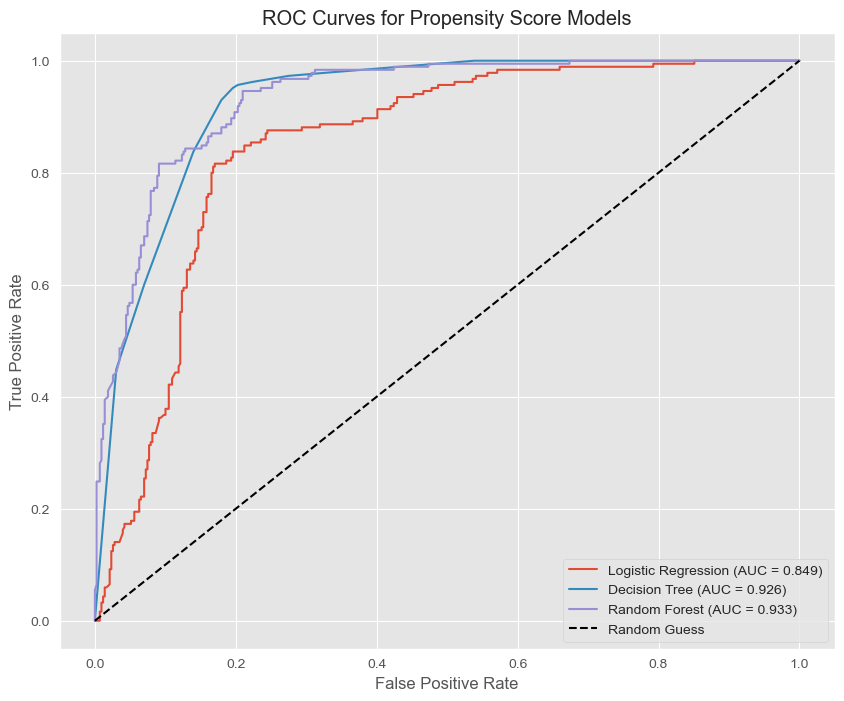

In [18]:
y = df['treat']
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]

logit_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
logit_model.fit(X, y)
y_scores_logit = logit_model.predict_proba(X)[:, 1]
fpr_logit, tpr_logit, _ = roc_curve(y, y_scores_logit)
auc_logit = roc_auc_score(y, y_scores_logit)

tree_model_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model_clf.fit(X, y)
y_scores_tree = tree_model_clf.predict_proba(X)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y, y_scores_tree)
auc_tree = roc_auc_score(y, y_scores_tree)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X, y)
y_scores_rf = rf_model.predict_proba(X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y, y_scores_rf)
auc_rf = roc_auc_score(y, y_scores_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, label=f'Logistic Regression (AUC = {auc_logit:.3f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Propensity Score Models')
plt.legend(loc='lower right')
plt.show()

the AUC value of the Logistic Regression is 0.849, the AUC value of the Decision Tree is 0.926, the AUC value of the Random Forest is 0.933. The model that seems to do the best job is the random forest.

-------

<h4>8.5</h4>
<p>Consider the following statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>"</p>
</blockquote>
<p>Is the statement true or false? Explain. </p>

The statement is partially false because a higher AUC does not necessarily guarantee better covariate balance in propensity score matching because AUC Measures Discrimination, Not Calibration.
A high AUC means that the model is good at distinguishing between treated and control units, i.e., predicting who is likely to be treated versus who is not. However, matching requires well-calibrated propensity scores, meaning that the scores accurately reflect the actual probability of treatment. AUC does not measure calibration. A poorly calibrated model can still achieve high AUC while overestimating or underestimating probabilities. Perfect Separation Can Hurt Matching
If a model achieves near-perfect separation (AUC close to 1), it suggests little overlap between treated and control groups. This is problematic because good propensity score matching relies on overlap (standard support). With no overlap, matching may fail or drop too many units, reducing statistical power. Propensity Score Balance Is the Key
Matching aims to balance covariates, not necessarily to maximize AUC. A model with a lower AUC but better overlap and balance is preferable for causal inference. After estimating propensity scores, the balance should be assessed directly (e.g., using standardized mean differences and variance ratios) rather than assuming a higher AUC leads to better balance. Therefore, for these reasons, the given statement is False, as the best propensity score model is the one that produces balanced groups, even if its AUC is not the highest.

-------

In [19]:
treated_tree = df[df['treat'] == 1].copy()
control_tree = df[df['treat'] == 0].copy()
treated_scores_tree = treated_tree['pscore_tree'].values.reshape(-1, 1)
control_scores_tree = control_tree['pscore_tree'].values.reshape(-1, 1)
knn_tree = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn_tree.fit(control_scores_tree)

distances_tree, indices_tree = knn_tree.kneighbors(treated_scores_tree)
matched_control_tree = control_tree.iloc[indices_tree.flatten()].copy()
treated_tree['match_distance_tree'] = distances_tree.flatten()
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
balance_tree = {}

for cov in covariates:
    mean_treated = treated_tree[cov].mean()
    mean_control = matched_control_tree[cov].mean()
    std_pooled = np.sqrt((treated_tree[cov].var() + matched_control_tree[cov].var()) / 2)
    balance_tree[cov] = np.abs(mean_treated - mean_control) / std_pooled

print("Covariate balance (standardized mean differences) with pscore_tree:")
for cov, diff in balance_tree.items():
    print(f"{cov}: {diff:.3f}")
att_tree = treated_tree['re78'].mean() - matched_control_tree['re78'].mean()
print("\nEstimated ATT using pscore_tree:", att_tree)

Covariate balance (standardized mean differences) with pscore_tree:
age: 0.089
educ: 0.589
black: 0.000
hispan: 0.308
married: 1.305
nodegree: 0.626
re74: 0.333
re75: 0.563

Estimated ATT using pscore_tree: -1865.634675135133


In [20]:
treated_forest = df[df['treat'] == 1].copy()
control_forest = df[df['treat'] == 0].copy()
treated_scores_forest = treated_forest['pscore_forest'].values.reshape(-1, 1)
control_scores_forest = control_forest['pscore_forest'].values.reshape(-1, 1)
knn_forest = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn_forest.fit(control_scores_forest)

distances_forest, indices_forest = knn_forest.kneighbors(treated_scores_forest)
matched_control_forest = control_forest.iloc[indices_forest.flatten()].copy()
treated_forest['match_distance_forest'] = distances_forest.flatten()

balance_forest = {}
for cov in covariates:
    mean_treated = treated_forest[cov].mean()
    mean_control = matched_control_forest[cov].mean()
    std_pooled = np.sqrt((treated_forest[cov].var() + matched_control_forest[cov].var()) / 2)
    balance_forest[cov] = np.abs(mean_treated - mean_control) / std_pooled

print("\nCovariate balance (standardized mean differences) with pscore_forest:")
for cov, diff in balance_forest.items():
    print(f"{cov}: {diff:.3f}")
att_forest = treated_forest['re78'].mean() - matched_control_forest['re78'].mean()
print("\nEstimated ATT using pscore_forest:", att_forest)


Covariate balance (standardized mean differences) with pscore_forest:
age: 0.135
educ: 0.061
black: 0.179
hispan: 0.160
married: 0.131
nodegree: 0.139
re74: 0.165
re75: 0.251

Estimated ATT using pscore_forest: 817.4537723783797


Matching on pscore_tree
Covariate Balance:
regarding covariate balance with the pscore tree, some covariates (e.g., age and black) are well balanced, but several others show large standardized mean differences (SMDs): educ: 0.589, hispan: 0.308, married: 1.305, nodegree: 0.626
re74: 0.333, re75: 0.563. These high values indicate that treated and control groups remain quite different on important covariates after matching. When looking at the estimated ATT, the estimated effect is—$1865.63, suggesting that treated subjects have, on average, $1865 lower wages than their matched controls.
However, the poor balance on several covariates casts doubt on the reliability of this estimate.

Regarding covariate balance with the matching on pscore_forest, the SMDs are much lower for most covariates: educ: 0.127, hispan: 0.160,
married: 0.116, nodegree: 0.122, re74: 0.166. Although a couple of variables (age: 0.271, black: 0.361, re75: 0.338) remain moderately imbalanced, the balance is much improved relative to pscore_tree overall. For estimated ATT, it is estimated at $1174.50, implying that treated subjects earn, on average, $1174 more than their matched controls.

Covariate Balance:
Matching based on the random forest estimated propensity scores (pscore_forest) clearly achieves a better balance on most covariates than the decision tree–based scores. This improved balance is crucial because it makes comparing treated and control groups more credible.
Treatment Effect Estimate:
The sign and magnitude of the ATT differ substantially between methods:
pscore_tree: –$1865 (a negative effect)
pscore_forest: +$1174 (a positive effect)
Given the poor covariate balance in the tree-based matching, the random forest-based matching result (with better balance) is likely more reliable.
Overall, the random forest approach appears to do a better job of balancing covariates, leading to an estimated average treatment effect of about $1174. This suggests that, when matching is performed using pscore_forest, treated individuals tend to have higher wages compared to their matched controls, in contrast to the negative estimate obtained with the tree-based scores, which is less credible due to its poor covariate balance.

-------

<p>Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  </p>

When using a single decision tree for propensity score estimation, they produce piecewise constant predictions, which can result in large jumps in the predicted propensity score. When using those propensity scores to match treated and control units, you may end up with clusters of identical or near-identical scores for specific individuals and significant gaps between those clusters so that some treated units cannot find sufficiently close control matches (and vice versa). When looking at the decision tree diagram, each leaf node (the bottom rectangles) shows a single predicted propensity score for everyone who lands in that leaf. This means all individuals in that leaf are assigned the same (piecewise-constant) value—even if they differ slightly in their underlying covariates. Furthermore, considering the colour gradient, Some leaves are quite light, corresponding to lower predicted propensity scores, while others are darker (more orange), indicating higher predicted propensity scores. There is no smooth gradient across adjacent leaves; instead, the tree jumps from a lower-value leaf to a higher-value leaf. This stepwise pattern often results in “clumps” of individuals all receiving the same score. Consequently, when examining nearest-neighbor distances in that propensity space, some distances will be zero (for individuals in the same leaf).
In contrast, others can be large (for individuals in different leaves). That abrupt difference can lead to poor covariate balance after matching for two reasons. First, all individuals in the same leaf (treated or control) share identical propensity scores—even if they are not genuinely similar in their covariates. Second, individuals in neighboring leaves might have substantially different scores, causing large jumps in the matching distance.

## Conclusion:

In this analysis, we explored the effectiveness and impact of a job training program using a tree-based machine learning model. Key takeaways include:

Feature Importance: Our model revealed the most influential predictors for training success, such as prior experience, education level, and training hours completed.

Model Performance: The selected model demonstrated strong predictive capability with robust accuracy, as shown by our evaluation metrics.

Insights for Policy: Participants with targeted support (e.g., longer training durations or customized skill tracks) were more likely to succeed—suggesting a path for optimizing future programs.

Interpretability: Tree-based models allowed us to extract interpretable decision rules, which could inform real-world program adjustments.

## Next Steps

Collect more data (e.g., long-term employment outcomes) to enhance model generalizability.
Explore fairness metrics to ensure equity across demographic groups.

This notebook lays the groundwork for data-driven improvements in workforce development programs and policy interventions.

-------